In [1]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam#
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [5]:
DIRECTORY = r"C:/Users/xps/Desktop/mouth/dataset"
CATEGORIES = ["silent", "speak"]

In [6]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

In [7]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [8]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [9]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [11]:
baseModel = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))


In [12]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [13]:
model = Model(inputs=baseModel.input, outputs=headModel)


In [14]:
for layer in baseModel.layers:
    layer.trainable = False

In [15]:
# compile model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
        metrics=["accuracy"])

[INFO] compiling model...


In [16]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
        aug.flow(trainX, trainY, batch_size=BS),
        steps_per_epoch=len(trainX) // BS,
        validation_data=(testX, testY),
        validation_steps=len(testX) // BS,
            epochs=EPOCHS)


[INFO] training head...
Epoch 1/20
98/98 [==============================] - 626s 6s/step - loss: 1.0053 - accuracy: 0.6172 - val_loss: 0.3449 - val_accuracy: 0.8777
Epoch 2/20
98/98 [==============================] - 564s 6s/step - loss: 0.5236 - accuracy: 0.7853 - val_loss: 0.2259 - val_accuracy: 0.9172
Epoch 3/20
98/98 [==============================] - 593s 6s/step - loss: 0.3657 - accuracy: 0.8622 - val_loss: 0.1789 - val_accuracy: 0.9389
Epoch 4/20
98/98 [==============================] - 514s 5s/step - loss: 0.2955 - accuracy: 0.8915 - val_loss: 0.1456 - val_accuracy: 0.9554
Epoch 5/20
98/98 [==============================] - 513s 5s/step - loss: 0.2448 - accuracy: 0.9105 - val_loss: 0.1222 - val_accuracy: 0.9643
Epoch 6/20
98/98 [==============================] - 514s 5s/step - loss: 0.2149 - accuracy: 0.9308 - val_loss: 0.1052 - val_accuracy: 0.9682
Epoch 7/20
98/98 [==============================] - 561s 6s/step - loss: 0.1941 - accuracy: 0.9382 - val_loss: 0.0943 - val_accura

In [17]:
predIdxs = model.predict(testX, batch_size=BS)

In [18]:
predIdxs = np.argmax(predIdxs, axis=1)


In [19]:
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

              precision    recall  f1-score   support

      silent       0.99      0.99      0.99       384
       speak       0.99      0.99      0.99       401

    accuracy                           0.99       785
   macro avg       0.99      0.99      0.99       785
weighted avg       0.99      0.99      0.99       785



In [20]:
print("[INFO] saving mask detector model...")
model.save("mouthes.model", save_format="h5")

[INFO] saving mask detector model...


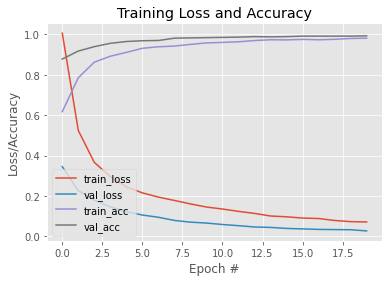

In [21]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [24]:
from keras.preprocessing import image
import numpy as np
from keras.models import load_model
def prepare_image(file):
    img = image.load_img( file, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array,axis=0)
    return preprocess_input(img_array_expanded_dims)
validpath=r'C:/Users/xps/Desktop/mask project/valid'
import cv2
import glob as gb
mobile=load_model("ResNet50.model")
class_labels=['Mask' ,'Without Mask']
files=gb.glob(pathname=str(validpath+'/*.jpg'))
for file in files :
    preprocessed_image = prepare_image(file)
    predictions = mobile.predict(preprocessed_image)
    for pred in predictions:
        (mask, withoutMask) = pred
        label = "Mask" if mask > withoutMask else "No Mask"
    label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
    print('status:',label)
    

In [1]:
from flask import Flask,render_template,Response,request
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import imutils
import cv2
import numpy as np
%tb
import imutils
app = Flask(__name__)
def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()
	#print(detections.shape)

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

# load our serialized face detector model from disk
prototxtPath = r"C:/Users/xps/Desktop/mask project/face_detector/deploy.prototxt"
weightsPath = r"C:/Users/xps/Desktop/mask project/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)
path="C:/Users/xps/Desktop/mask project/vgg.model"
# load the face mask detector model from disk
maskNet = load_model("vgg.model")
def mask():
    print("[INFO] starting video stream...")
    #vs = VideoStream(src=0).start()
    camera=cv2.VideoCapture(0)
    # loop over the frames from the video stream
    while True:
    # grab the frame from the threaded video stream and resize it
    # to have a maximum width of 400 pixels
   
        success,frame = camera.read()
        if not success:
            break
        else:
            frame = imutils.resize(frame, width=800)

            # detect faces in the frame and determine if they are wearing a
            # face mask or not
            (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

            # loop over the detected face locations and their corresponding
            # locations
            for (box, pred) in zip(locs, preds):
                # unpack the bounding box and predictions
                (startX, startY, endX, endY) = box
                (mask, withoutMask) = pred

                # determine the class label and color we'll use to draw
                # the bounding box and text
                label = "Mask" if mask > withoutMask else "No Mask"
                color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
                if label== "No Mask":
                    print("dangerous")
                    gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
                # include the probability in the label
                label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

                # display the label and bounding box rectangle on the output
                # frame
                cv2.putText(frame, label, (startX, startY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
                cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
            ret, buffer = cv2.imencode('.jpg', frame)
            frame = buffer.tobytes()
            yield (b'--frame\r\n'
                    b'Content-Type: image/jpeg\r\n\r\n' + frame + b'\r\n')

@app.route('/', methods=['POST', "get"])
def reaction():
        return render_template('react.html')
@app.route('/react_vedio', methods=['POST', "get"])
def react_vedio():
        return Response(mask(),
                    mimetype="multipart/x-mixed-replace; boundary=frame")  
if __name__ == '__main__':
    app.run(port=3000)


No traceback available to show.


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:3000/ (Press CTRL+C to quit)
127.0.0.1 - - [21/May/2022 10:42:30] "GET / HTTP/1.1" 200 -


[INFO] starting video stream...


127.0.0.1 - - [21/May/2022 10:42:30] "GET /static//css/background3.jpg HTTP/1.1" 308 -
127.0.0.1 - - [21/May/2022 10:42:31] "GET /static/css/background3.jpg HTTP/1.1" 200 -


[INFO] starting video stream...


127.0.0.1 - - [21/May/2022 10:43:46] "GET /react_vedio HTTP/1.1" 200 -


dangerous
dangerous


In [25]:
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
import cv2
import numpy as np
import dlib
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input, decode_predictions
classifier =load_model("ResNet50.model")
face_detection=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
path="C:/Users/xps/Desktop/test/shape_predictor_68_face_landmarks.dat"
face_detector=dlib.shape_predictor(path)
detector=dlib.get_frontal_face_detector()
cap = cv2.VideoCapture(0)
while True:
    # Grab a single frame of video
    ret, frame = cap.read()
    if ret== False :
        break
    class_labels=['silent','speak']
    gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    face=detector(gray)
    faces = face_detection.detectMultiScale(gray,1.3,4)
    for fac in face:
            landmarks=face_detector(gray,fac)
            x5=landmarks.part(3).x
            y5=landmarks.part(3).y

            for (x,y,w,h) in faces:
                
                cv2.rectangle(frame,(x5,y5),(x+w,y+h),(0,255,0),2)
                roi_gray = frame[y5:y+h,x5:x+w]
                if np.sum([roi_gray])!=0:
                    roi_gray = cv2.resize(roi_gray,(224,224),interpolation=cv2.INTER_AREA)

                    roi = roi_gray.astype('float')/255.0
                    roi = img_to_array(roi)
                    roi=preprocess_input(roi)
                    roi = np.expand_dims(roi,axis=0)

                # make a prediction on the ROI, then lookup the class

                    preds = classifier.predict(roi)[0]
                    label=class_labels[preds.argmax()]
                    
                    
                    label_position = (x,y)
                    cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),2)
                else:
                    cv2.putText(frame,'No Face Found',(20,60),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
    cv2.imshow('Emotion Detector',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
dir=['ahmed sayed','abdelhakem','ali','islam','ashraf','yasser','ahmed drahim','Abo bakr','ahmed ashref'
,'ahmed hesham','ahmed mosad','ahmed saaid','ahmed samir','ahmed shaban','ahmed shalan','amer yasser',
'amged saber','amr eissa','amr salam','bassem','ezz-eldin','fady maher','Hassan mohamed','ibrahim',
'ibrahim ali','ibrahim walid','islam elsawy','maged essam','mahmoud salma','mahmoud shokry','mahomed drahim',
 'mamdouh nabil','moaz hesham','mohamed adel','mohamed aymen','mohamed gomaa','mohamed ramden','mohmed emad'
 ,'mostafa abdo','mostafa mahmoud'
 ,'omar mahmoud','omar tharwat','ramdan','saif emad','saif mohamed','shreif ekramy','shreif samy','taher elshikh'
 ,'yousef mahmoud','zeyad fayek']